In [2]:
import pandas as pd
import requests
import time
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import elasticsearch
import os
pd.options.plotting.backend = "plotly"

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
avg_over_min = 1
days_look_back = 90

In [5]:
en_date = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
st_date = (datetime.now() - timedelta(days=days_look_back)).strftime('%Y-%m-%dT%H:%M:%S')

en_date_dt = datetime.now().astimezone(pytz.timezone('America/New_York'))
st_date_dt = (datetime.now() - timedelta(days=days_look_back)).astimezone(pytz.timezone('America/New_York'))

st_date_utc = datetime.strptime(st_date, '%Y-%m-%dT%H:%M:%S').astimezone(pytz.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')
en_date_utc = datetime.strptime(en_date, '%Y-%m-%dT%H:%M:%S').astimezone(pytz.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')

In [7]:
print(st_date_utc)
print(en_date_utc)

2022-01-08T16:28:42Z
2022-04-08T15:28:42Z


In [8]:
# Import and format Praxis data
uri = 'https://aws.southcoastscience.com/topicMessages?topic=nyu/brooklyn/loc/3/particulates&' \
'startTime=%s&endTime=%s&checkpoint=**:/%i:00' \
% (st_date_utc, en_date_utc, avg_over_min)
print(uri)
praxis_df = pd.DataFrame([])

while uri != '':
    header = {"authorization": "api-key nyu-brooklyn"}
    response = requests.get(uri, headers=header)
    json = response.json()

    data = {}

    data['ts'] = pd.to_datetime([ele['rec'] for ele in json['Items']]).tz_convert(tz='US/Eastern')

    data['praxis_pm1_vals'] = [ele['val']['pm1'] for ele in json['Items']]
    data['praxis_pm2p5_vals'] = [ele['val']['pm2p5'] for ele in json['Items']]
    data['praxis_pm10_vals'] = [ele['val']['pm10'] for ele in json['Items']]

    data['praxis_pm1_vals_adj'] = [ele['exg']['rn20']['pm1'] for ele in json['Items']]
    data['praxis_pm2p5_vals_adj'] = [ele['exg']['rn20']['pm2p5'] for ele in json['Items']]
    data['praxis_pm10_vals_adj'] = [ele['exg']['rn20']['pm10'] for ele in json['Items']]

#     praxis_df = pd.DataFrame(data).set_index('ts').resample(avg_over).mean()

    if 'next' in json:
        uri = json['next']
    else:
        uri = ''
    praxis_df = pd.concat([praxis_df, pd.DataFrame(data)])
    
    time.sleep(0.5)
praxis_df = praxis_df.set_index('ts').resample('%iT' % avg_over_min).mean()
praxis_df = praxis_df.loc[st_date_dt:en_date_dt]

https://aws.southcoastscience.com/topicMessages?topic=nyu/brooklyn/loc/3/particulates&startTime=2022-01-08T16:28:42Z&endTime=2022-04-08T15:28:42Z&checkpoint=**:/1:00


In [11]:
praxis_df

,praxis_pm1_vals,praxis_pm2p5_vals,praxis_pm10_vals,praxis_pm1_vals_adj,praxis_pm2p5_vals_adj,praxis_pm10_vals_adj
ts,,,,,,
2022-01-08 11:29:00-05:00,1.0,2.8,49.5,1.5,2.8,38.5
2022-01-08 11:30:00-05:00,1.0,3.8,18.8,1.4,2.6,17.0
2022-01-08 11:31:00-05:00,0.9,2.6,18.4,1.5,2.7,13.5
2022-01-08 11:32:00-05:00,1.0,2.6,13.5,1.4,2.9,17.0
2022-01-08 11:33:00-05:00,1.0,3.5,28.7,1.7,3.2,19.8
...,...,...,...,...,...,...
2022-04-08 11:24:00-04:00,0.7,2.1,7.9,2.8,5.9,15.7
2022-04-08 11:25:00-04:00,0.6,1.9,6.7,2.4,4.8,11.2
2022-04-08 11:26:00-04:00,0.6,2.1,7.6,2.8,5.4,15.8


In [3]:
# Import and format Piera Canary data
# 168
canary_df = pd.DataFrame([])

for x in range(840):
    uri = 'https://sensei.pierasystems.com/api/get-minute-averages/318?page=%i' % x
    response = requests.get(uri)
    json = response.json()
    data = {}
    if json["data"] == "":
        break
    data['ts'] = pd.to_datetime([ele['time'] for ele in json['data']]).tz_convert(tz='US/Eastern')
    
    data['canary_pm1_vals'] = [ele['pm10'] for ele in json['data']]
    data['canary_pm2p5_vals'] = [ele['pm25'] for ele in json['data']]
    data['canary_pm10_vals'] = [ele['pm100'] for ele in json['data']]
    
    canary_df = pd.concat([canary_df, pd.DataFrame(data)])

    if canary_df['ts'].iloc[-1] < pd.DatetimeIndex([st_date_dt]):
        break
    time.sleep(0.5)
    
canary_df = canary_df.set_index('ts').resample('%iT' % avg_over_min).mean()
canary_df = canary_df.loc[st_date_dt:en_date_dt]

NameError: name 'st_date_dt' is not defined

In [61]:
canary_df.index
#canary_df.loc[st_date_dt:en_date_dt]

DatetimeIndex(['2022-02-11 01:38:00-05:00', '2022-02-11 01:39:00-05:00',
               '2022-02-11 01:40:00-05:00', '2022-02-11 01:41:00-05:00',
               '2022-02-11 01:42:00-05:00', '2022-02-11 01:43:00-05:00',
               '2022-02-11 01:44:00-05:00', '2022-02-11 01:45:00-05:00',
               '2022-02-11 01:46:00-05:00', '2022-02-11 01:47:00-05:00',
               ...
               '2022-03-29 10:46:00-04:00', '2022-03-29 10:47:00-04:00',
               '2022-03-29 10:48:00-04:00', '2022-03-29 10:49:00-04:00',
               '2022-03-29 10:50:00-04:00', '2022-03-29 10:51:00-04:00',
               '2022-03-29 10:52:00-04:00', '2022-03-29 10:53:00-04:00',
               '2022-03-29 10:54:00-04:00', '2022-03-29 10:55:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='ts', length=66738, freq='T')

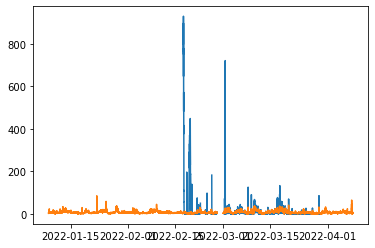

In [57]:

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(canary_df.index,canary_df["canary_pm2p5_vals"])
plt.plot(praxis_df.index,praxis_df["praxis_pm2p5_vals_adj"])

In [6]:
uri = 'https://api.thingspeak.com/channels/1530870/feeds.json?api_key=U4IJYTKQ1ON601M3&average=%i&days=%i' \
% (avg_over_min, days_look_back)
print(uri)
response = requests.get(uri)
json = response.json()
data = {}
data['ts'] = pd.to_datetime([ele['created_at'] for ele in json['feeds']]).tz_convert(tz='US/Eastern')
    
data['purple_pm1_vals'] = [ele['field1'] for ele in json['feeds']]
data['purple_pm2p5_vals'] = [ele['field2'] for ele in json['feeds']]
data['purple_pm10_vals'] = [ele['field3'] for ele in json['feeds']]

purple_df = pd.DataFrame(data)
    
# purple_df = purple_df.set_index('ts').resample('%iT' % avg_over_min).mean().interpolate(method='pad', limit=2)
purple_df = purple_df.set_index('ts').resample('%iT' % avg_over_min).mean()
purple_df = purple_df.loc[st_date_dt:en_date_dt]

https://api.thingspeak.com/channels/1530870/feeds.json?api_key=U4IJYTKQ1ON601M3&average=1&days=90


TypeError: 'int' object is not subscriptable

In [19]:
purple_df

,purple_pm1_vals,purple_pm2p5_vals,purple_pm10_vals
ts,,,
2022-03-28 08:04:00-04:00,0.00,0.00,0.00
2022-03-28 08:05:00-04:00,NaN,NaN,NaN
2022-03-28 08:06:00-04:00,0.00,0.00,0.00
2022-03-28 08:07:00-04:00,NaN,NaN,NaN
2022-03-28 08:08:00-04:00,0.00,0.00,0.00
...,...,...,...
2022-04-08 11:24:00-04:00,NaN,NaN,NaN
2022-04-08 11:25:00-04:00,0.00,0.09,0.54
2022-04-08 11:26:00-04:00,NaN,NaN,NaN


In [20]:
comb_df = canary_df.join(praxis_df)
comb_df = comb_df.join(purple_df)

In [21]:
GROUP = time.time()

def scroll(es, index, body, scroll='2m', size=1000, timeout=25, **kw):
    if isinstance(timeout, int):
        timeout = '{}s'.format(int(timeout))
    page = es.search(index=index, body=body, scroll=scroll, size=size, timeout=timeout, **kw)
    scroll_id, hits = page['_scroll_id'], page['hits']['hits']
    while len(hits):
        yield hits
        page = es.scroll(scroll_id=scroll_id, scroll=scroll)
        scroll_id, hits = page['_scroll_id'], page['hits']['hits']
        
def sensor_query(key=None, nodeid=None, start=None, end=None, k_time="time", group=GROUP):
    match = []
    if key and nodeid:
        match.append({"term": {f'{key}.keyword': nodeid}})
    end = end or 'now'
    if start:
        match.append({"range" : {k_time : {"gte" : start, "lte" : end}}})
    elif end:
        match.append({"range" : {k_time : {"lte" : end}}})
    return { "query": { "bool": {"must": match} } } if match else {}

def download_sensor_data(table, key=None, nodeid=None, start=None, end=None, save=True, k_time='time', **kw):
    query = sensor_query(key, nodeid, start, end, k_time=k_time, **kw)
    print(query)
    
    def pull():
        with tqdm(scroll(es, table, query)) as pbar:
            for i, hits in enumerate(pbar):
                hits = [h['_source'] for h in hits]
                times = [h[k_time] for h in hits]
                pbar.write('{}. n hits: {}. {} - {}'.format(i, len(hits), min(times), max(times)))
                for h in hits:
                    yield h
    if not save:
        return list(pull())

    fname = 'data/{}/{}.json'.format(group, nodeid or table)
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    print(f'Pulling node={nodeid} for ({start} -> {end}) ... saving to {fname}')
    with open(fname, 'w') as f:
        for h in pull():
            f.write(json.dumps(h) + '\n')
    print('all done!')
    return fname

In [22]:
from importlib import reload
import settings
reload(settings)
es = elasticsearch.Elasticsearch('https://es.master1.sonycproject.com', http_auth=('elastic', settings.es_password))

ModuleNotFoundError: No module named 'settings'

In [ ]:
# ss[0]['aq']

In [ ]:
ss = download_sensor_data('status', 'fqdn', 'sonycnode-dca632ceb48d', start='now-%id' % days_look_back, save=False)
data = {}
data['ts'] = pd.to_datetime([datetime.fromtimestamp(int(ele['aq']['dt'])) for ele in ss]).tz_localize(tz='US/Eastern')
    
data['piera7100_pm1_vals'] = [ele['aq']['PM1.0'] for ele in ss]
data['piera7100_pm2p5_vals'] = [ele['aq']['PM2.5'] for ele in ss]
data['piera7100_pm10_vals'] = [ele['aq']['PM10'] for ele in ss]

piera7100_df = pd.DataFrame(data)
    
piera7100_df = piera7100_df.set_index('ts').resample('%iT' % avg_over_min).mean()
# purple_df = purple_df.set_index('ts').resample('%iT' % avg_over_min).mean()
piera7100_df = piera7100_df.loc[st_date_dt:en_date_dt]

{'query': {'bool': {'must': [{'term': {'fqdn.keyword': 'sonycnode-dca632ceb48d'}}, {'range': {'time': {'gte': 'now-31d', 'lte': 'now'}}}]}}}


0it [00:00, ?it/s]

0. n hits: 1000. 2022-03-09T03:00:17.591246 - 2022-03-09T09:09:43.445163
1. n hits: 1000. 2022-03-09T03:00:57.608910 - 2022-03-09T09:14:23.567126
2. n hits: 1000. 2022-03-09T02:58:47.591551 - 2022-03-09T09:23:13.638847
3. n hits: 1000. 2022-03-09T02:58:57.493965 - 2022-03-09T09:23:38.670577
4. n hits: 1000. 2022-03-09T02:58:37.563025 - 2022-03-23T17:05:40.704118
5. n hits: 1000. 2022-03-23T15:12:43.693689 - 2022-03-23T18:06:41.764401
6. n hits: 1000. 2022-03-23T11:41:29.876371 - 2022-03-23T18:18:11.904173
7. n hits: 1000. 2022-03-23T06:45:19.438312 - 2022-03-23T18:37:22.224147
8. n hits: 1000. 2022-03-23T06:43:49.435952 - 2022-03-23T11:40:14.891574
9. n hits: 1000. 2022-03-23T06:44:24.430949 - 2022-03-23T11:40:24.809006
10. n hits: 1000. 2022-03-23T06:52:39.568073 - 2022-03-23T14:48:08.268454
11. n hits: 1000. 2022-03-23T09:37:12.551927 - 2022-03-23T15:10:03.714385
12. n hits: 1000. 2022-03-23T12:53:01.274388 - 2022-03-23T22:42:56.745429
13. n hits: 1000. 2022-03-23T18:39:37.259492 - 2

112. n hits: 1000. 2022-03-08T19:19:55.464564 - 2022-03-08T22:34:58.276767
113. n hits: 1000. 2022-03-08T22:34:38.330270 - 2022-03-09T22:26:00.917446
114. n hits: 1000. 2022-03-09T18:52:02.625104 - 2022-03-09T23:27:06.880443
115. n hits: 1000. 2022-03-09T18:54:07.787874 - 2022-03-10T05:52:08.053320
116. n hits: 1000. 2022-03-10T04:25:06.829665 - 2022-03-10T07:44:44.856649
117. n hits: 1000. 2022-03-08T09:01:05.552715 - 2022-03-10T08:45:50.962033
118. n hits: 1000. 2022-03-08T09:27:05.920007 - 2022-03-08T10:50:22.331700
119. n hits: 1000. 2022-03-08T10:50:27.315723 - 2022-03-08T12:16:23.840122
120. n hits: 1000. 2022-03-08T12:16:28.788944 - 2022-03-10T01:58:24.385600
121. n hits: 1000. 2022-03-09T19:08:12.913102 - 2022-03-10T01:46:29.054244
122. n hits: 1000. 2022-03-10T01:46:04.124339 - 2022-03-10T07:50:24.923321
123. n hits: 1000. 2022-03-10T06:05:13.260821 - 2022-03-15T10:47:20.477669
124. n hits: 1000. 2022-03-15T06:01:30.677589 - 2022-03-15T11:49:16.515218
125. n hits: 1000. 2022-0

223. n hits: 1000. 2022-03-17T14:30:14.242523 - 2022-03-17T16:07:36.919935
224. n hits: 1000. 2022-03-17T16:07:41.880944 - 2022-03-17T18:28:06.644614
225. n hits: 1000. 2022-03-17T04:30:14.699179 - 2022-03-17T19:03:01.376763
226. n hits: 1000. 2022-03-17T05:35:45.822704 - 2022-03-17T06:59:02.150850
227. n hits: 1000. 2022-03-17T06:59:07.046921 - 2022-03-17T08:22:23.409026
228. n hits: 1000. 2022-03-17T08:22:28.436686 - 2022-03-17T09:45:44.682109
229. n hits: 1000. 2022-03-17T09:45:49.787031 - 2022-03-17T11:09:36.094961
230. n hits: 1000. 2022-03-17T11:09:41.117409 - 2022-03-22T13:48:21.958228
231. n hits: 1000. 2022-03-22T13:46:31.966238 - 2022-03-22T15:10:03.268428
232. n hits: 1000. 2022-03-16T19:45:51.288933 - 2022-03-22T15:43:28.952846
233. n hits: 1000. 2022-03-16T23:53:50.239103 - 2022-03-17T02:21:37.656631
234. n hits: 1000. 2022-03-16T23:53:45.237347 - 2022-03-18T04:10:55.824906
235. n hits: 1000. 2022-03-17T02:35:02.777140 - 2022-03-17T04:02:59.381798
236. n hits: 1000. 2022-0

KeyError: 'aq'

In [ ]:
piera7100_df

In [ ]:
comb_df = comb_df.join(piera7100_df)

In [ ]:
comb_df

In [ ]:
# fig = comb_df[['canary_pm2p5_vals', 'praxis_pm2p5_vals_adj', 'praxis_pm2p5_vals', 'purple_pm2p5_vals', 'piera7100_pm2p5_vals']].plot();
fig = comb_df[['canary_pm2p5_vals', 'praxis_pm2p5_vals_adj', 'praxis_pm2p5_vals', 'purple_pm2p5_vals']].plot();
fig.show()